# Homework Wet Assignment 3 - Regression

In [7]:
# imports

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from LinearRegressor import LinearRegressor as LR
from test_lr import test_lr
from verify_gradients import compare_gradients

## Preliminary: Updated Data Loading

### Load data

In [8]:
# load data set
def load_data(filename) -> np.ndarray:
    with open(f'data/{filename}') as file:
        data = pd.read_csv(file)
        return data

dataset = load_data('virus_data.csv')

# divide to train and test using the ID's (same method as in Wet HW 1)
id1 = 21
id2 = 9
train = dataset.sample(frac=0.8, random_state=id1 + id2)
test = dataset.drop(train.index)

In [9]:
# make sure data is loaded correctly (commented in submission)
# assignment 2 data used

# train_hw2_path = '../wet_hw2/data/train_prepared.csv'
# test_hw2_path = '../wet_hw2/data/test_prepared.csv'
#
# def equals(l1, l2):
#     return len(l1) == len(l2) and all(v == u for v, u in zip(l1, l2))
#
#
# with open(train_hw2_path) as file:
#     train_hw2_data = pd.read_csv(file, index_col=0)
#     assert equals(train_hw2_data['patient_id'], train['patient_id'])
#
# with open(test_hw2_path) as file:
#     test_hw2_data = pd.read_csv(file, index_col=0)
#     assert equals(test_hw2_data['patient_id'], test['patient_id'])

### Preprocessing
Exactly as done in Wet HW 1.

In [10]:
def fill_numeric_nan_with_median(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col_name in df.columns:
        if df[col_name].dtype.kind in 'biufc':
            value = df[col_name].median()
        # else:
        #     value = df[col_name].mode(dropna=True)
        #     value = value.iloc[0] if not value.empty else None
            df[col_name] = df[col_name].fillna(value)
    return df

def normalize(
        test: pd.DataFrame,
        train: pd.DataFrame,
        mm_scale_columns: list,
        z_scale_columns: list
) -> (pd.DataFrame, pd.DataFrame):
    scaler_mm = MinMaxScaler(feature_range=(-1, 1))
    scaler_z = StandardScaler()

     # Fit on train only, transform both train and test
    train[mm_scale_columns] = scaler_mm.fit_transform(train[mm_scale_columns])
    test[mm_scale_columns] = scaler_mm.transform(test[mm_scale_columns])

    train[z_scale_columns] = scaler_z.fit_transform(train[z_scale_columns])
    test[z_scale_columns] = scaler_z.transform(test[z_scale_columns])
    return train, test

train = fill_numeric_nan_with_median(train)
test = fill_numeric_nan_with_median(test)

mm_scale_columns = ['PCR_01', 'PCR_02', 'PCR_04', 'PCR_06', 'PCR_08']
z_scale_columns = ['PCR_03', 'PCR_05', 'PCR_07', 'PCR_09', 'PCR_10']
train, test = normalize(train, test, mm_scale_columns, z_scale_columns)

## Section 1: Linear regression implementation

### load new division for the dataset

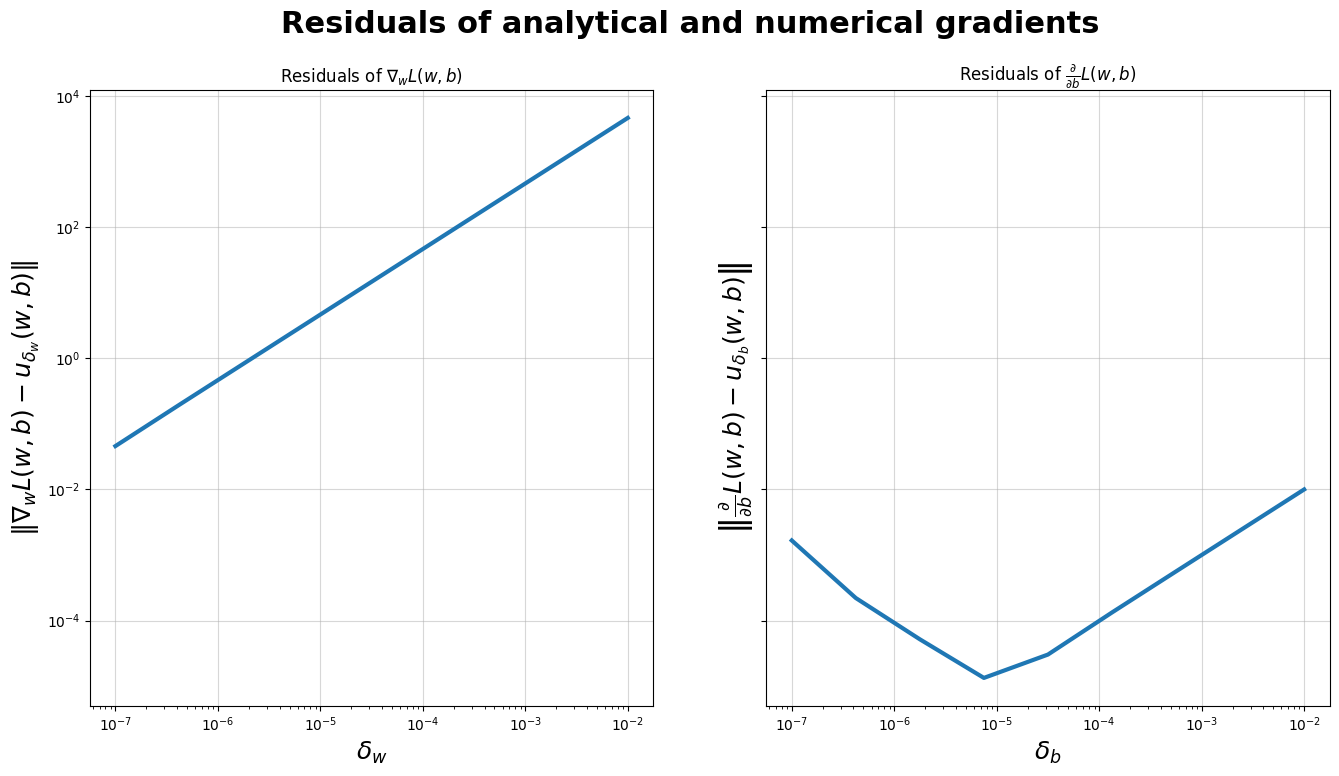

In [11]:
# divide to train and test using the ID's (same method as in Wet HW 1)
train_new = train.sample(frac=0.8)
validation_new = train.drop(train_new.index)

train_new = fill_numeric_nan_with_median(train_new)
validation_new = fill_numeric_nan_with_median(validation_new)
train_new, validation_new = normalize(train_new, validation_new, mm_scale_columns, z_scale_columns)
X_train = train_new.drop(columns=['contamination_level']).to_numpy()
y_train = train_new['contamination_level'].to_numpy()

X_val = validation_new.drop(columns=['contamination_level']).to_numpy()
y_val = validation_new['contamination_level'].to_numpy()

compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))

### Q2

### Q3

Checking X_train...
 - Any NaNs: False
 - Any Infs: False
 - Any non-finite values: False
Checking y_train...
 - Any NaNs: False
 - Any Infs: False
 - Any non-finite values: False
Checking X_val...
 - Any NaNs: False
 - Any Infs: False
 - Any non-finite values: False
Checking y_val...
 - Any NaNs: False
 - Any Infs: False
 - Any non-finite values: False
lr size = 1e-09, Best train loss = 0.06344887585910448, Best validation loss = 0.06074506779539515
lr size = 1e-08, Best train loss = 0.049993124934271285, Best validation loss = 0.050826955810943826
lr size = 1e-07, Best train loss = 0.02711880613561626, Best validation loss = 0.030055411938982743
lr size = 1e-06, Best train loss = 0.025064380968300767, Best validation loss = 0.028604566040240142


C:\Dev\ML-02360766\venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Dev\ML-02360766\wet_hw3\LinearRegressor.py:48: RuntimeWarning: overflow encountered in square
  loss = (1. / m) * np.sum(inner_loss ** 2)
C:\Dev\ML-02360766\wet_hw3\LinearRegressor.py:66: RuntimeWarning: overflow encountered in matmul
  g_w = (2. / m) * (X.T @ inner_grad)
C:\Dev\ML-02360766\wet_hw3\LinearRegressor.py:66: RuntimeWarning: invalid value encountered in matmul
  g_w = (2. / m) * (X.T @ inner_grad)
C:\Dev\ML-02360766\wet_hw3\LinearRegressor.py:105: RuntimeWarning: invalid value encountered in subtract
  self.w -= self.lr * g_w


lr size = 1e-05, Best train loss = 0.1383190758558983, Best validation loss = 0.13655788437603403
lr size = 0.0001, Best train loss = 0.1383190758558983, Best validation loss = 0.13655788437603403
lr size = 0.001, Best train loss = 0.1383190758558983, Best validation loss = 0.13655788437603403
lr size = 0.01, Best train loss = 0.1383190758558983, Best validation loss = 0.13655788437603403
lr size = 0.1, Best train loss = 0.1383190758558983, Best validation loss = 0.13655788437603403


C:\Dev\ML-02360766\venv\Lib\site-packages\matplotlib\scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


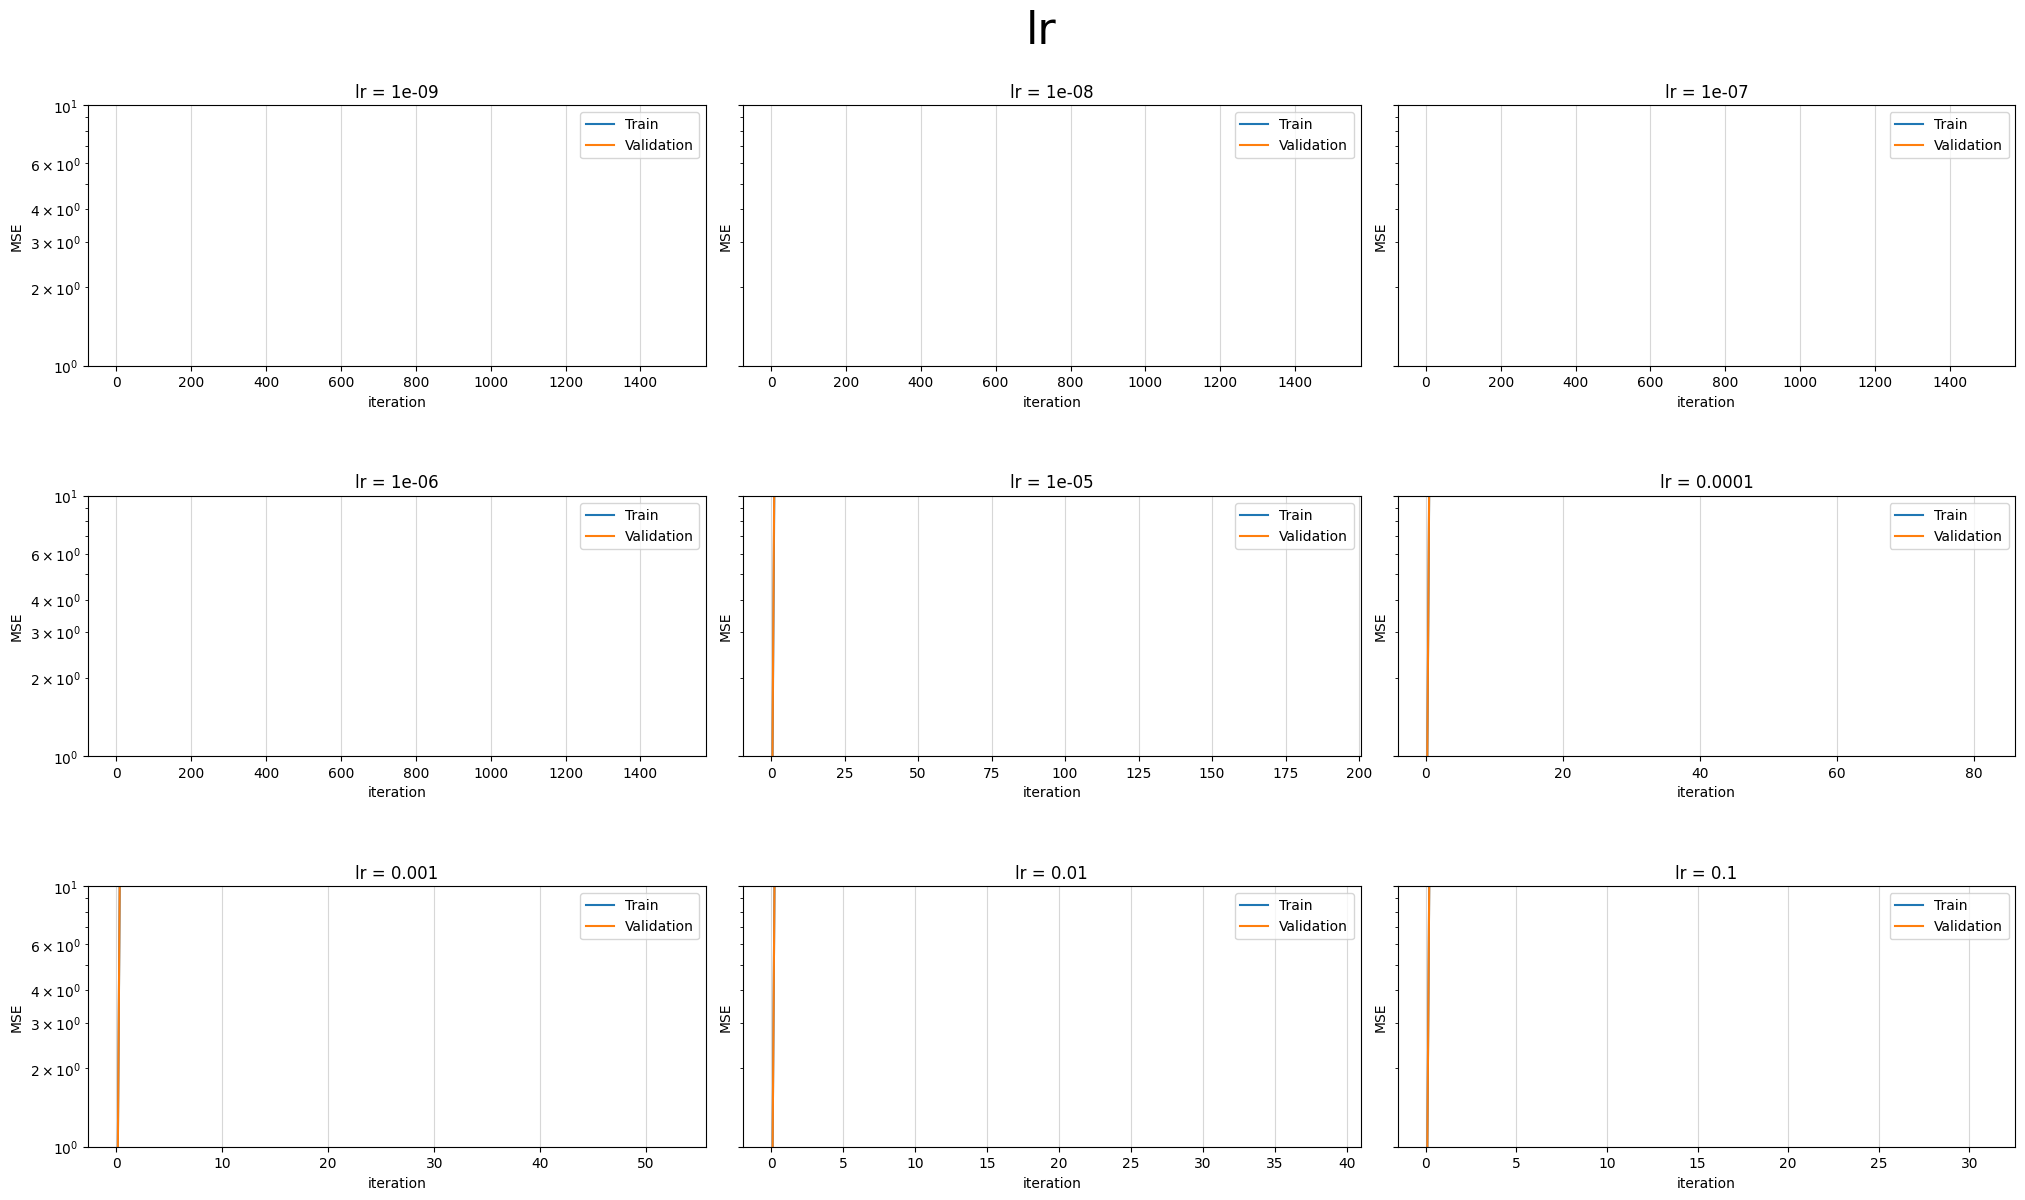

In [12]:
def check_nan_inf(df, name="Data"):
    print(f"Checking {name}...")
    print(" - Any NaNs:", df.isna().values.any())
    print(" - Any Infs:", np.isinf(df.values).any())
    print(" - Any non-finite values:", not np.all(np.isfinite(df.values)))

check_nan_inf(pd.DataFrame(X_train), "X_train")
check_nan_inf(pd.Series(y_train), "y_train")
check_nan_inf(pd.DataFrame(X_val), "X_val")
check_nan_inf(pd.Series(y_val), "y_val")
test_lr(X_train, y_train, X_val, y_val, title='lr')